In [1]:
import sys
import os
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from itables import show
from importlib import reload
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc, f1_score, average_precision_score
from sklearn.model_selection import train_test_split

# Automatické přenačítání modulů při změně
%load_ext autoreload
%autoreload 2

# Přidání složky 'src' do cesty Pythonu
current_dir = os.getcwd()
src_dir = os.path.abspath(os.path.join(current_dir, '..', 'src'))
if src_dir not in sys.path:
    sys.path.append(src_dir)

# Import našich modulů
import config
import models
import load_preprocess_data as loader 
import analysis
import visualization as viz
import analysis as ana

# Nastavení
pd.set_option('display.max_rows', 500)
viz.setup_style()

⚙️ Konfigurace načtena. Používám zařízení: cpu
🎨 Vizualizační styl nastaven: whitegrid


### Data Loading Funkce

In [2]:
def load_data_s2(scenario, pooling='mean', test_size=0.2, random_state=42):
    """
    Načte data pro Sentence-Level experimenty.
    Pro 'robustness' přidává i kontextové věty, aby vyvážil množství Silver anomálií.
    """
    base_gold = config.VECTORS_DIR / 'gold'
    base_silver = config.VECTORS_DIR / 'silver'
    
    # Cesty
    path_gold_l0 = base_gold / f"gold_sent_{pooling}_l0.pkl"
    path_gold_l1 = base_gold / f"gold_sent_{pooling}_l1.pkl"
    path_silver_l1 = base_silver / f"silver_sent_{pooling}_l1.pkl"
    # Cesta ke kontextovým větám (považujeme za L0 - Neutral)
    path_gold_context = base_gold / f"gold_context_sent_{pooling}.pkl"

    def load_pkl(path):
        if path.exists():
            with open(path, 'rb') as f: return pickle.load(f)
        else:
            print(f"⚠️ Warning: Soubor neexistuje: {path}")
            return np.array([])

    g_l0 = load_pkl(path_gold_l0)
    g_l1 = load_pkl(path_gold_l1)
    
    # --- SCÉNÁŘE ---
    
    if scenario == 'baseline':
        # Pouze čisté Gold věty
        X = np.concatenate([g_l0, g_l1])
        y = np.concatenate([np.zeros(len(g_l0)), np.ones(len(g_l1))])
        
    elif scenario == 'robustness':
        # 1. Anomálie: Gold L1 + Silver L1
        s_l1 = load_pkl(path_silver_l1)
        all_l1 = np.concatenate([g_l1, s_l1])
        
        # 2. Neutrální: Gold L0 + Gold Context (aby jich bylo dostatek)
        g_context = load_pkl(path_gold_context)
        all_l0 = np.concatenate([g_l0, g_context])
        
        # Data Check uvnitř funkce (pro info)
        # print(f"   [Robustness info] L1: {len(all_l1)}, L0: {len(all_l0)}")
        
        X = np.concatenate([all_l0, all_l1])
        y = np.concatenate([np.zeros(len(all_l0)), np.ones(len(all_l1))])
        
    else:
        raise ValueError(f"Unknown scenario: {scenario}")

    return train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)

### Data-check

In [3]:
print("🔍 DATA CHECK (Počty vzorků):")
print("-" * 60)

for pool in ['mean']:
    for scen in ['baseline', 'robustness']:
        try:
            X_tr, X_te, y_tr, y_te = load_data_s2(scen, pooling=pool)
            
            n_total = len(y_tr) + len(y_te)
            n_anomalies = sum(y_tr) + sum(y_te)
            n_neutral = n_total - n_anomalies
            ratio = n_anomalies / n_total
            
            print(f"👉 [{pool.upper()} - {scen}]")
            print(f"   Celkem: {n_total} (Train: {len(X_tr)}, Test: {len(X_te)})")
            print(f"   Neutrální (L0): {int(n_neutral)}")
            print(f"   Anomálie  (L1): {int(n_anomalies)}")
            print(f"   Anomaly Ratio:  {ratio:.2f} (Podíl L1 v datasetu)")
            print("-" * 60)
            
        except Exception as e:
            print(f"⚠️ Chyba u {pool}/{scen}: {e}")

🔍 DATA CHECK (Počty vzorků):
------------------------------------------------------------
👉 [MEAN - baseline]
   Celkem: 520 (Train: 416, Test: 104)
   Neutrální (L0): 188
   Anomálie  (L1): 332
   Anomaly Ratio:  0.64 (Podíl L1 v datasetu)
------------------------------------------------------------
👉 [MEAN - robustness]
   Celkem: 2512 (Train: 2009, Test: 503)
   Neutrální (L0): 1228
   Anomálie  (L1): 1284
   Anomaly Ratio:  0.51 (Podíl L1 v datasetu)
------------------------------------------------------------


### Training Loop

In [4]:
# --- POMOCNÁ FUNKCE PRO VÝPOČET METRIK ---
def calculate_detailed_metrics(y_true, y_probs, prefix="test"):
    """
    Vypočítá sadu metrik (AUPRC, ROC-AUC, Max F1) pro daná data.
    Vrací dictionary s prefixem (např. 'train_' nebo 'test_').
    """
    # 1. AUPRC a Křivky
    precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
    auprc = auc(recall, precision)
    
    # 2. ROC AUC (Ošetření pro případ jedné třídy)
    try:
        roc_auc = roc_auc_score(y_true, y_probs)
    except ValueError:
        roc_auc = 0.5 

    # 3. Max F1 Score (Hledání optimálního prahu)
    # F1 = 2 * (P * R) / (P + R)
    numerator = 2 * precision * recall
    denominator = precision + recall
    # Ošetření dělení nulou
    f1_scores = np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator!=0)
    
    # Najdeme index nejlepšího F1
    best_idx = np.argmax(f1_scores)
    max_f1 = f1_scores[best_idx]
    
    # Precision a Recall v tomto bodě
    prec_at_max = precision[best_idx]
    rec_at_max = recall[best_idx]
    
    return {
        f'{prefix}_auprc': auprc,
        f'{prefix}_roc_auc': roc_auc,
        f'{prefix}_max_f1': max_f1,
        f'{prefix}_precision_at_max_f1': prec_at_max,
        f'{prefix}_recall_at_max_f1': rec_at_max
    }

In [5]:
# --- KONFIGURACE EXPERIMENTU ---
MODEL_NAMES = ["LogReg", "SVM (RBF)", "XGBoost", "Dummy", "SVM (Lin)", "NaiveBayes", "RandForest"]
POOLING_METHODS = ['mean', 'cls']
SCENARIOS = ['baseline', 'robustness'] # S2a, S2b
RESULTS_PATH = config.RESULTS_DIR / "M2_S2_experiment_results.csv"

results = []

# Pokud soubor existuje, načteme ho (volitelné, pro navázání)
# if RESULTS_PATH.exists(): results = pd.read_csv(RESULTS_PATH).to_dict('records')

In [6]:
%%script false

print(f"🚀 STARTING M2 S2 EXPERIMENTS (Total runs: {len(MODEL_NAMES) * len(POOLING_METHODS) * len(SCENARIOS)})")

# Progress bar přes všechny kombinace
total_iter = len(POOLING_METHODS) * len(SCENARIOS) * len(MODEL_NAMES)
pbar = tqdm(total=total_iter)

for pooling in POOLING_METHODS:
    for scenario in SCENARIOS:
        
        # 1. Načtení dat
        X_train, X_test, y_train, y_test = load_data_s2(scenario, pooling=pooling)
        
        for model_name in MODEL_NAMES:
            pbar.set_description(f"Processing: {pooling} | {scenario} | {model_name}")
            
            try:
                # 2. Inicializace a trénink
                clf = models.get_supervised_model(model_name)
                clf.fit(X_train, y_train)
                
                # 3. Získání pravděpodobností (pro Train i Test)
                # Musíme řešit modely bez predict_proba (SVM Lin, Dummy někdy)
                if hasattr(clf, "predict_proba"):
                    y_train_probs = clf.predict_proba(X_train)[:, 1]
                    y_test_probs = clf.predict_proba(X_test)[:, 1]
                else:
                    # Fallback na decision_function a normalizaci
                    tr_dec = clf.decision_function(X_train)
                    te_dec = clf.decision_function(X_test)
                    # Min-Max Scaling do 0-1 pro výpočet metrik
                    _min, _max = tr_dec.min(), tr_dec.max() # Škálovat podle Train range
                    y_train_probs = (tr_dec - _min) / (_max - _min)
                    y_test_probs = (te_dec - _min) / (_max - _min)

                # 4. Výpočet metrik
                metrics_train = calculate_detailed_metrics(y_train, y_train_probs, prefix="train")
                metrics_test = calculate_detailed_metrics(y_test, y_test_probs, prefix="test")
                
                # 5. Uložení výsledku
                res = {
                    'model': model_name,
                    'scenario': scenario,
                    'pooling': pooling,
                    'n_train': len(X_train),
                    'n_test': len(X_test)
                }
                # Spojení slovníků (Python 3.9+ syntax by byla res | metrics_train | metrics_test)
                res.update(metrics_train)
                res.update(metrics_test)
                
                results.append(res)
                
                # Průběžné ukládání
                pd.DataFrame(results).to_csv(RESULTS_PATH, index=False)
                
            except Exception as e:
                print(f"❌ Error u {model_name} ({pooling}/{scenario}): {e}")
            
            pbar.update(1)

pbar.close()
print("✅ Experimenty dokončeny.")

Couldn't find program: 'false'


### Anylýza výsledků

In [7]:
# 1. Načtení
df_results = pd.read_csv(RESULTS_PATH)

# 2. Pivot Table: Srovnání AUPRC
# Řádky: Model
# Sloupce: MultiIndex (Pooling, Scenario)
pivot_df = df_results.pivot_table(
    index='model', 
    columns=['pooling', 'scenario'], 
    values='test_auprc'
)

# Seřazení podle průměru (orientačně)
pivot_df['mean_score'] = pivot_df.mean(axis=1)
pivot_df = pivot_df.sort_values('mean_score', ascending=False).drop(columns='mean_score')

print("📊 VÝSLEDKY AUPRC (Pooling vs Scenario)")
show(pivot_df)

show(df_results)

📊 VÝSLEDKY AUPRC (Pooling vs Scenario)


Loading ITables v2.6.2 from the internet... (need help?)


Loading ITables v2.6.2 from the internet... (need help?)


📊 DETAILNÍ SROVNÁNÍ: MEAN vs CLS (Train/Test)


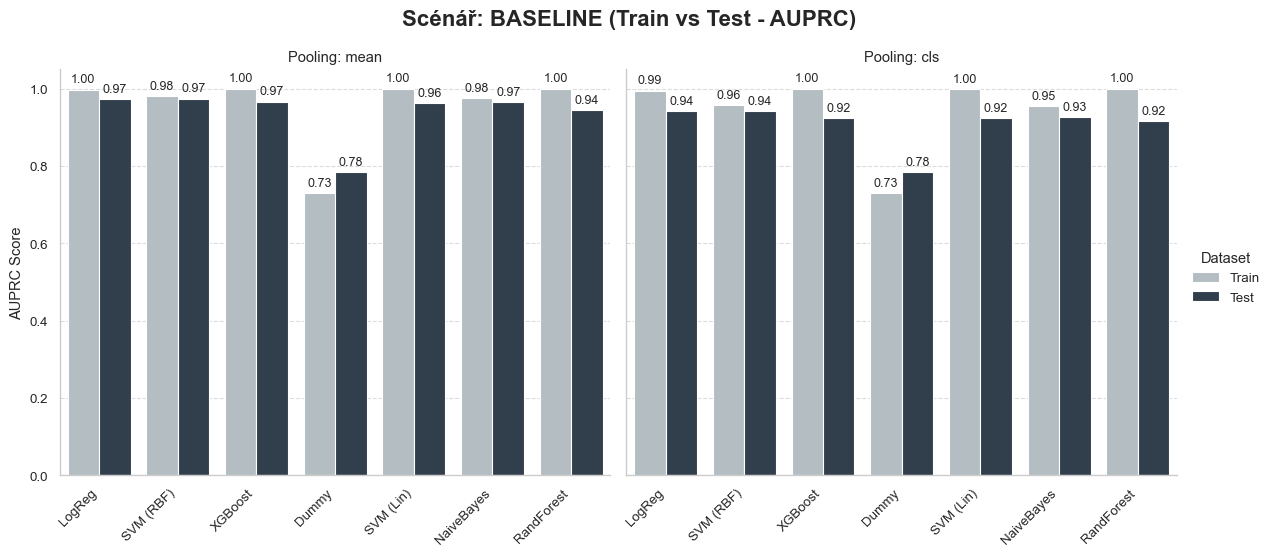

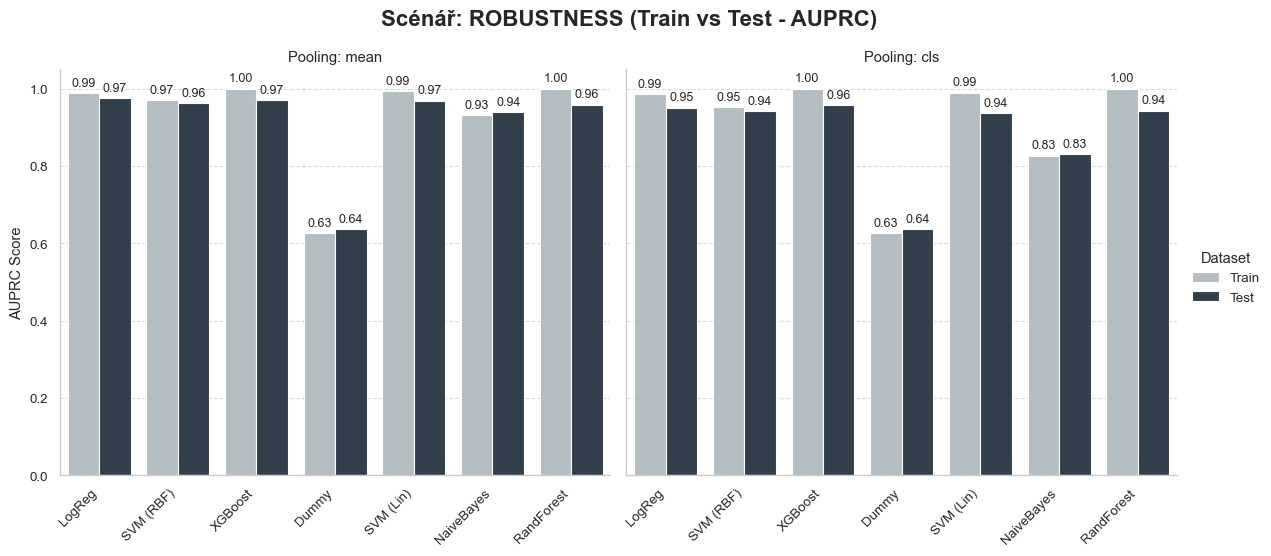

In [8]:
import visualization as viz
from importlib import reload
reload(viz)

# Vykreslení breakdownu (Train vs Test) podle Poolingu
print("📊 DETAILNÍ SROVNÁNÍ: MEAN vs CLS (Train/Test)")
viz.plot_pooling_breakdown(df_results, metric='auprc')

# Můžete zkusit i pro F1
# viz.plot_pooling_breakdown(df_results, metric='max_f1')

### Výběr nejlepšího modelu, retraining a analýza

In [9]:
# =============================================================================
# 🏆 1. VÝBĚR A PŘETRÉNOVÁNÍ VÍTĚZE
# =============================================================================

# A) Najdeme nejlepší konfiguraci podle AUPRC (nebo Max F1)
metric_col = 'test_auprc' 
best_run = df_results.sort_values(by=metric_col, ascending=False).iloc[0]

best_model_name = best_run['model']
best_scenario = best_run['scenario']
best_pooling = best_run['pooling']

print(f"🌟 VÍTĚZNÝ EXPERIMENT (Sentence Level):")
print(f"   Model:    {best_model_name}")
print(f"   Scénář:   {best_scenario}")
print(f"   Pooling:  {best_pooling.upper()}")
print(f"   Skóre:    {best_run[metric_col]:.4f} ({metric_col})")

# B) Načtení dat přesně pro tuto konfiguraci
print(f"\n🔄 Načítám data...")
X_train, X_test, y_train, y_test = load_data_s2(
    scenario=best_scenario,
    pooling=best_pooling,
    random_state=42
)

# C) Retraining (abychom měli 'živý' model)
print(f"🛠️  Přetrénovávám model...")
clf = models.get_supervised_model(best_model_name)
clf.fit(X_train, y_train)

# D) Predikce pro vizualizaci
if hasattr(clf, "predict_proba"):
    y_probs = clf.predict_proba(X_test)[:, 1]
else:
    # Fallback pro modely bez probability (např. SVM Linear)
    d_func = clf.decision_function(X_test)
    y_probs = (d_func - d_func.min()) / (d_func.max() - d_func.min())

y_pred = clf.predict(X_test)

🌟 VÍTĚZNÝ EXPERIMENT (Sentence Level):
   Model:    LogReg
   Scénář:   robustness
   Pooling:  MEAN
   Skóre:    0.9744 (test_auprc)

🔄 Načítám data...
🛠️  Přetrénovávám model...



📊 A. KLASICKÉ METRIKY


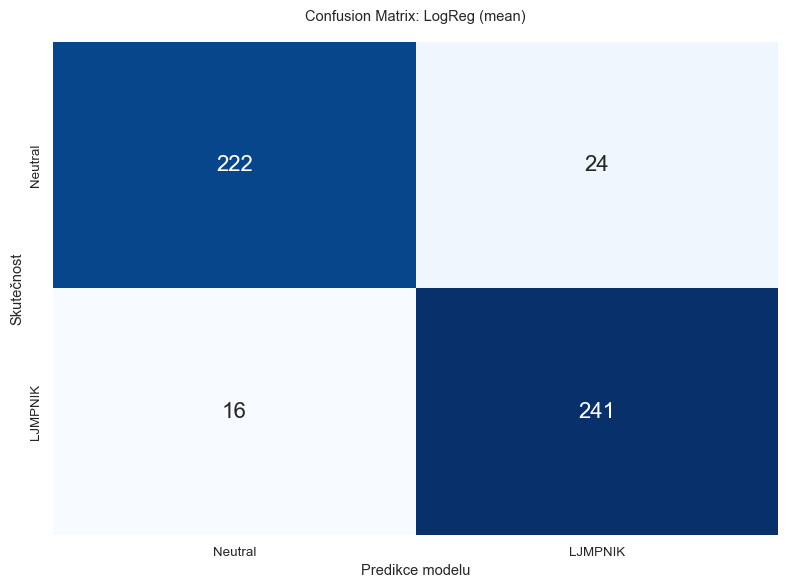

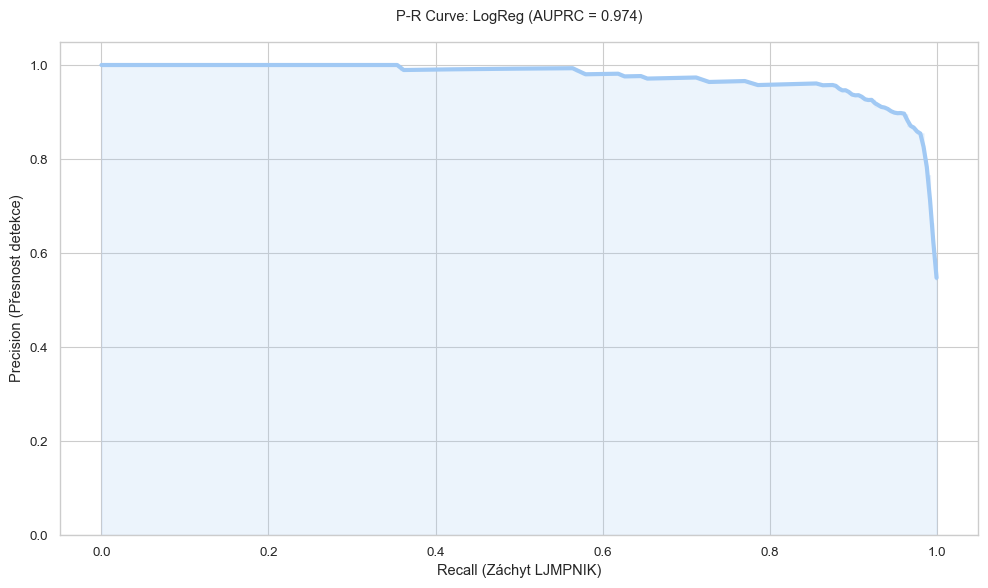


📊 B. KALIBRACE A RYSY


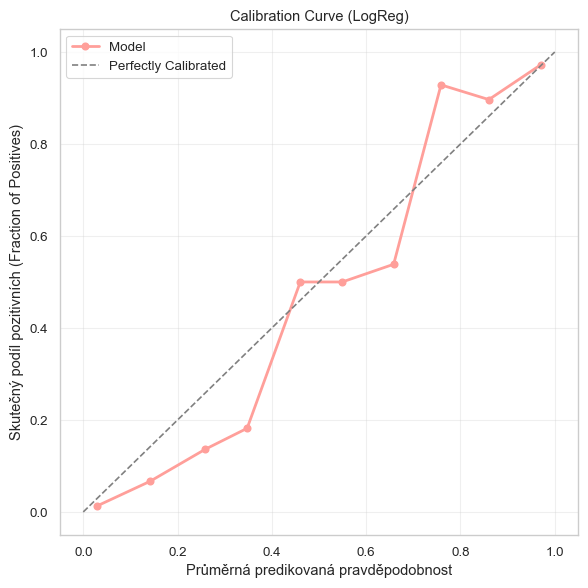

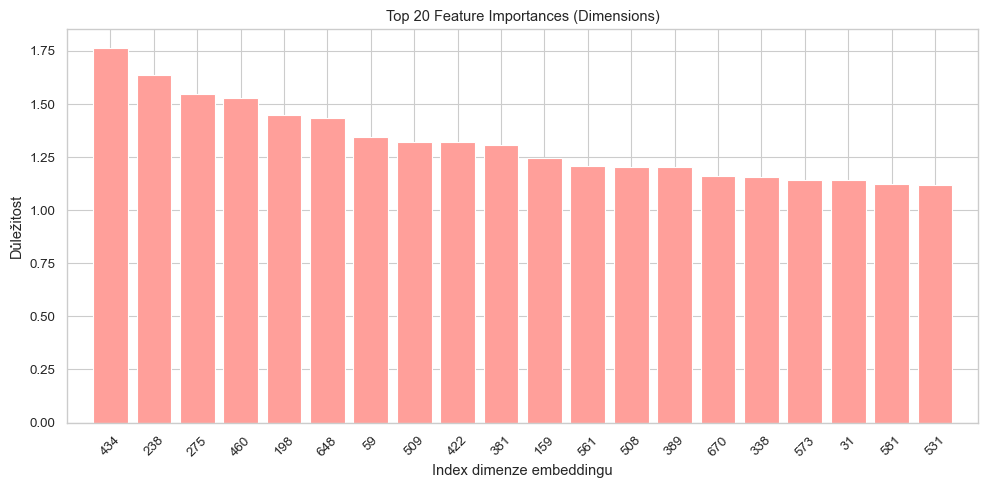

In [10]:
print("\n📊 A. KLASICKÉ METRIKY")
viz.plot_confusion_matrix_heatmap(y_test, y_pred, title=f"Confusion Matrix: {best_model_name} ({best_pooling})")
viz.plot_pr_curve(y_test, y_probs, title=f"P-R Curve: {best_model_name}")

print("\n📊 B. KALIBRACE A RYSY")
viz.plot_model_calibration(y_test, y_probs, title=f"Calibration Curve ({best_model_name})")
# Feature importance (ukáže důležité dimenze embeddingu)
viz.plot_feature_importance(clf, top_n=20)


📊 C. ANALÝZA CHYB V PROSTORU (Error Analysis)
   ⏳ Počítám projekce...
1️⃣ Počítám PCA...
3️⃣ Počítám UMAP...
   🔹 Vykresluji PCA...


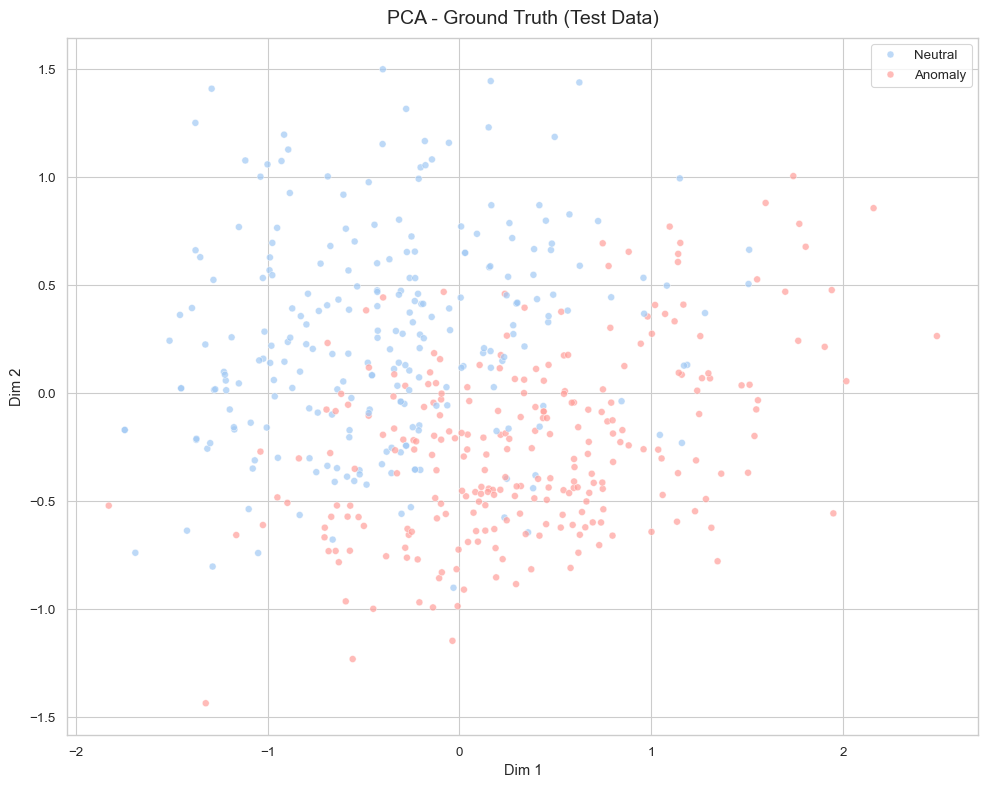

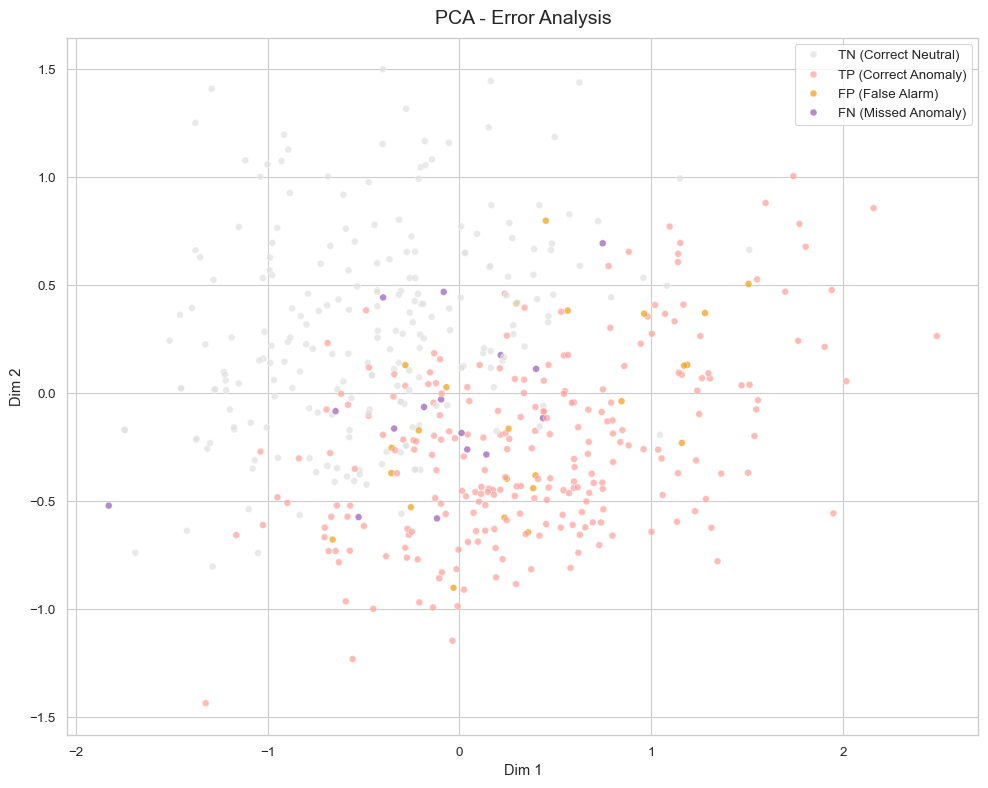

   🔹 Vykresluji UMAP...


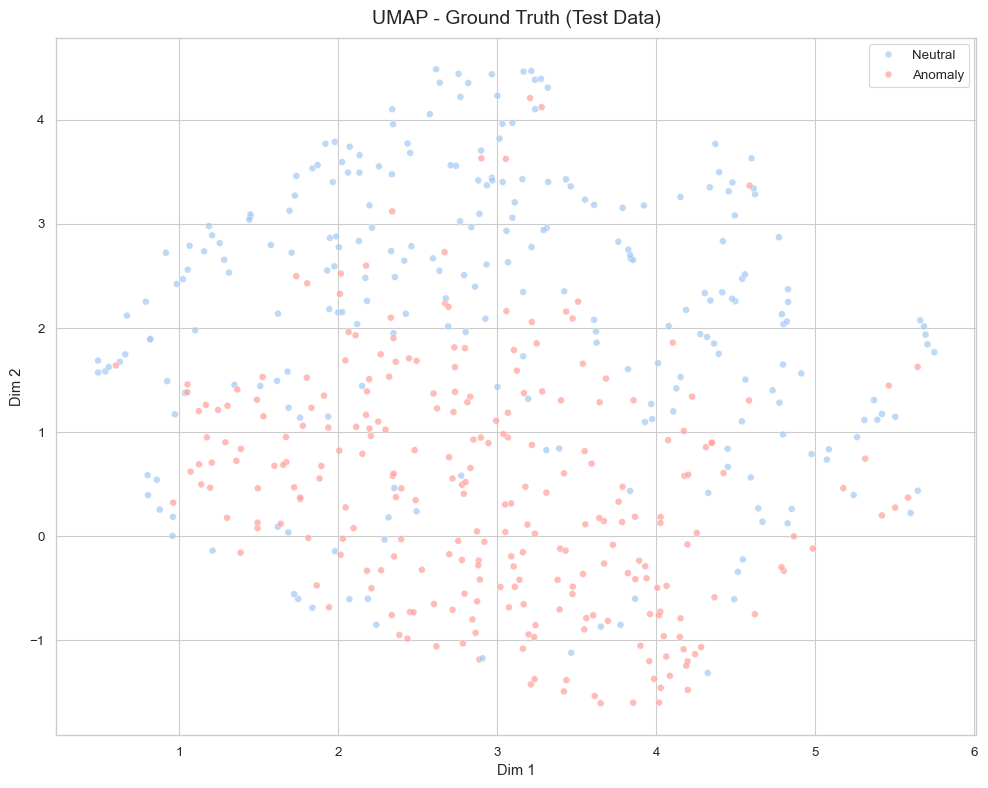

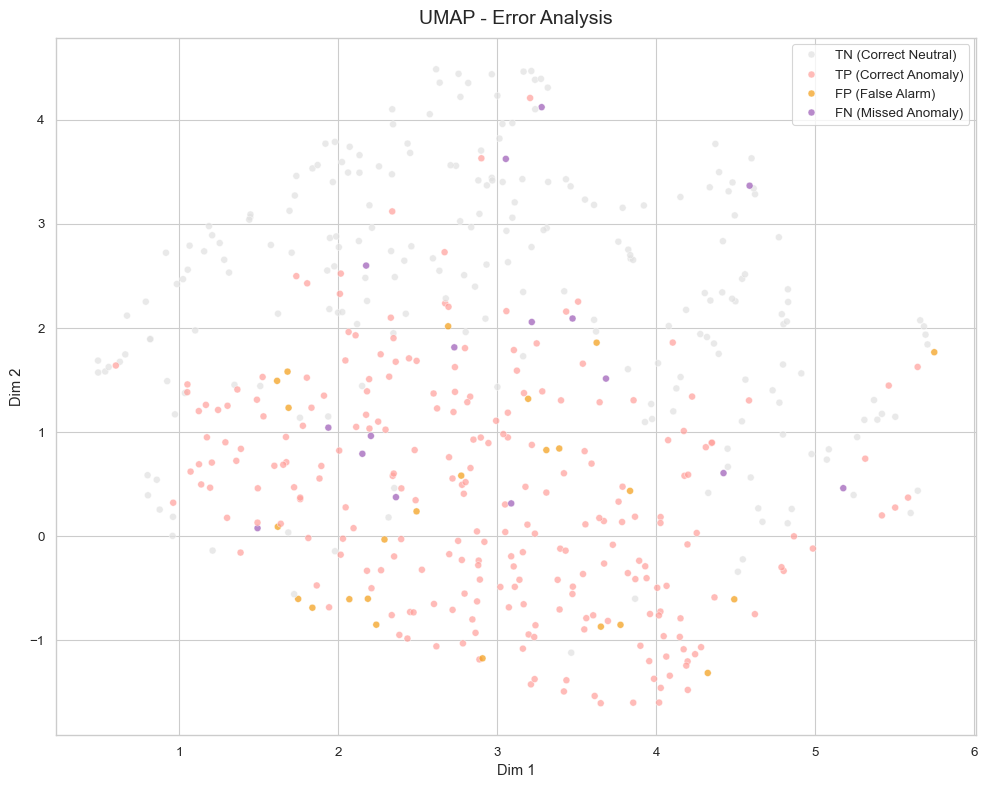

In [11]:
print("\n📊 C. ANALÝZA CHYB V PROSTORU (Error Analysis)")
# 1. Výpočet projekcí (PCA/UMAP)
# U vět bývá méně dat než u tokenů, takže subsampling možná nebude nutný, 
# ale pro jistotu ho tam necháme (max_samples=2000).
print("   ⏳ Počítám projekce...")
projections, indices = viz.compute_projections(
    X_test, 
    methods=['PCA', 'UMAP'], 
    max_samples=2000
)

# Synchronizace indexů (pokud proběhl subsampling)
y_test_sub = y_test[indices]
y_pred_sub = y_pred[indices]

# 2. Vykreslení
for method, coords in projections.items():
    print(f"   🔹 Vykresluji {method}...")
    
    # Ground Truth
    viz.plot_embedding_projection(
        coords, 
        ['Anomaly' if y==1 else 'Neutral' for y in y_test_sub], 
        palette={'Neutral': config.COLORS['l0'], 'Anomaly': config.COLORS['l1']},
        title=f"{method} - Ground Truth (Test Data)"
    )
    
    # Error Analysis (Kde model chybuje?)
    viz.plot_error_analysis_projection(
        coords, 
        y_test_sub, 
        y_pred_sub, 
        method_name=method
    )

## Kvalitatnivní analýza

In [ ]:
reload(ana)

print("🕵️ ZAHAJUJI KVALITATIVNÍ ANALÝZU...")

# 1. Načtení zdrojových textů (JSONL)
path_gold = config.INTERIM_DIR / 'GOLD_data_processed.jsonl'
path_silver = config.INTERIM_DIR / 'SILVER_data_processed.jsonl'

raw_gold = ana.load_jsonl_texts(path_gold)
raw_silver = ana.load_jsonl_texts(path_silver)

# 2. Extrakce základních textů (Target Sentences)
g_txt_l0, g_txt_l1 = ana.get_flat_texts_and_labels(raw_gold, level='sentence')
s_txt_l0, s_txt_l1 = ana.get_flat_texts_and_labels(raw_silver, level='sentence')

# 3. Extrakce KONTEXTOVÝCH vět (Nutné pro Robustness scénář!)
# Musíme iterovat přes data a vytahovat context_prev/next ve stejném pořadí,
# jako to dělal skript při generování vektorů (load_preprocess_data.py).
context_texts = []
for entry in raw_gold:
    # Podíváme se, pro které věty byly vygenerovány vektory
    s_vecs = entry.get('sentence_vectors', {})
    
    # Pořadí musí sedět: nejdřív '0' (prev), pak '2' (next)
    if '0' in s_vecs:
        context_texts.append(entry.get('context_prev'))
    if '2' in s_vecs:
        context_texts.append(entry.get('context_next'))

context_texts = np.array(context_texts)
print(f"   Načteno {len(context_texts)} kontextových vět z GOLD dat.")

# 4. Rekonstrukce scénáře
print(f"   Rekonstruuji texty pro scénář: {best_scenario}")

texts_X = []
texts_y = []

if best_scenario == 'baseline':
    # S2a: Gold L0 + Gold L1
    texts_X = np.concatenate([g_txt_l0, g_txt_l1])
    texts_y = np.concatenate([np.zeros(len(g_txt_l0)), np.ones(len(g_txt_l1))])

elif best_scenario == 'robustness':
    # S2b: Gold L0 + Context + Gold L1 + Silver L1
    
    # Anomálie (L1)
    all_l1 = np.concatenate([g_txt_l1, s_txt_l1])
    
    # Neutral (L0) = Target L0 + Context
    all_l0 = np.concatenate([g_txt_l0, context_texts])
    
    texts_X = np.concatenate([all_l0, all_l1])
    texts_y = np.concatenate([np.zeros(len(all_l0)), np.ones(len(all_l1))])

# 5. Split (STEJNÝ SEED 42!)
# Pokud to sedí, train_test_split nám vrátí texty odpovídající X_test
_, texts_test, _, _ = train_test_split(
    texts_X, texts_y, 
    test_size=0.2, 
    stratify=texts_y, 
    random_state=42
)

print(f"   Mám {len(texts_test)} textových řetězců pro testovací sadu.")
print(f"   Mám {len(X_test)} testovacích vektorů.")

# Teď už by to mělo projít
if len(texts_test) != len(X_test):
    print(f"❌ STÁLE NESEDÍ: Texty {len(texts_test)} vs Vektory {len(X_test)}")
    # Debug: Zkusíme zjistit rozdíl
    diff = len(X_test) - len(texts_test)
    print(f"   Rozdíl je {diff}. (Pokud je kladný, chybí nám texty).")
else:
    print("✅ Počty sedí! Spouštím analýzu...")
    
    # 6. Analýza
    df_analysis = ana.create_analysis_df(clf, X_test, y_test, texts_test)
    
    # 7. Výpisy
    ana.show_top_anomalies(df_analysis, n=15)
    print("-" * 80)
    ana.show_worst_errors(df_analysis, error_type='FP', n=10)
    print("-" * 80)
    ana.show_worst_errors(df_analysis, error_type='FN', n=10)

[autoreload of analysis failed: Traceback (most recent call last):
  File "c:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\venv\Lib\site-packages\IPython\extensions\autoreload.py", line 322, in check
    elif self.deduper_reloader.maybe_reload_module(m):
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\venv\Lib\site-packages\IPython\extensions\deduperreload\deduperreload.py", line 545, in maybe_reload_module
    new_source_code = f.read()
                      ^^^^^^^^
  File "C:\Users\dobes\Documents\Anaconda Python\Lib\encodings\cp1250.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeDecodeError: 'charmap' codec can't decode byte 0x81 in position 256: character maps to <undefined>
]


ZAHAJUJI KVALITATIVNÍ ANALÝZU...
Dostupné klíče: dict_keys(['context_prev', 'target_sentence', 'context_next', 'target_token', 'label', 'source', 'tokens', 'sentence_vectors'])
   Rekonstruuji texty pro scénář: robustness
   Mám 295 textových řetězců pro testovací sadu.
   Mám 503 testovacích vektorů.


AssertionError: ❌ POZOR: Počet textů a vektorů nesedí! Zkontrolujte logiku načítání.